In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.decomposition import PCA

import xgboost as xgb
import shap
import joblib
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('/content/Breast Cancer Wisconsin.csv')
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [3]:
df = df.drop('id', axis=1)
df.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


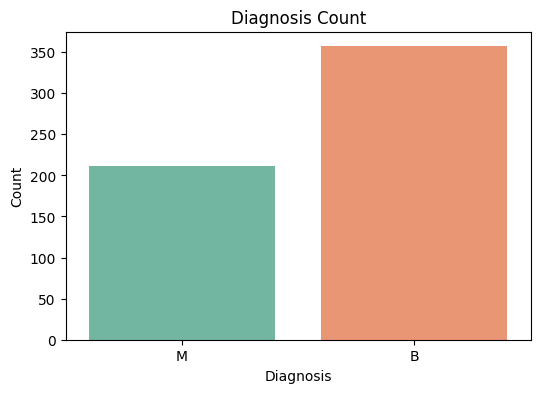

In [4]:
plt.figure(figsize=(6,4))
sns.countplot(x='diagnosis', data=df, palette='Set2')
plt.title('Diagnosis Count')
plt.xlabel('Diagnosis')
plt.ylabel('Count')
plt.show()

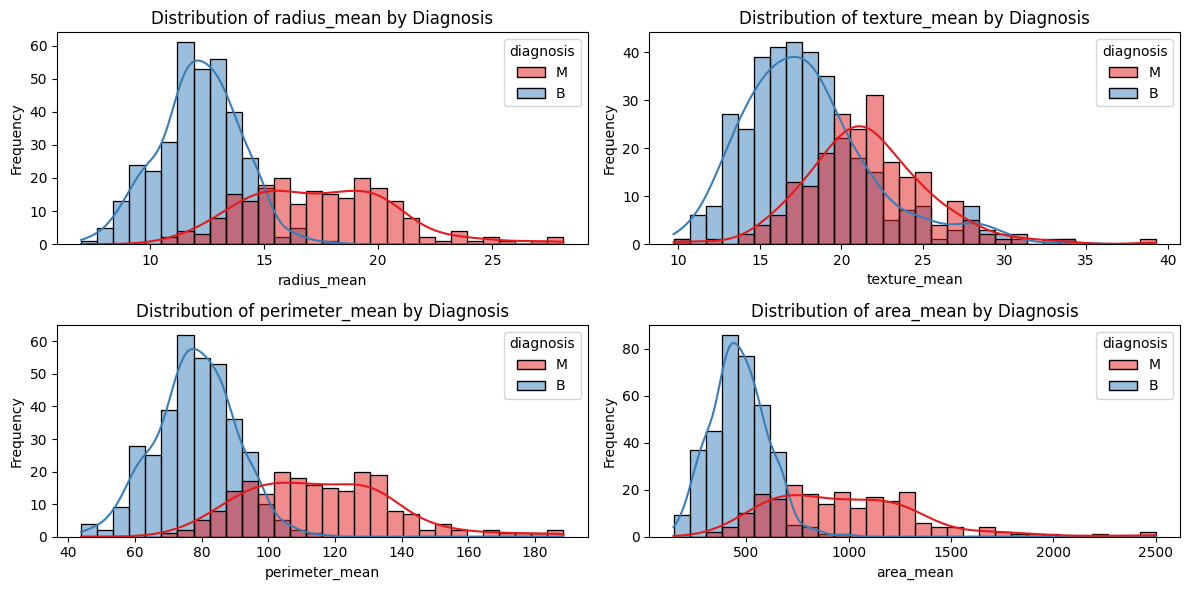

In [9]:
features = ['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean']

plt.figure(figsize=(12,6))
for i, col in enumerate(features):
  plt.subplot(2,2,i+1)
  sns.histplot(data=df, x=col, hue='diagnosis', bins=30, kde=True,
               palette='Set1')
  plt.title(f'Distribution of {col} by Diagnosis')
  plt.xlabel(col)
  plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

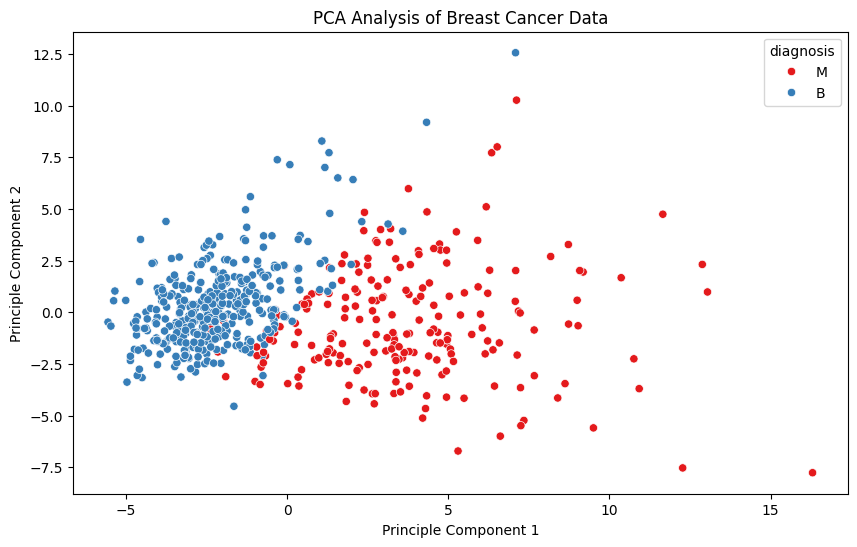

In [12]:
x = df.drop(columns = ['diagnosis'])
x = (x - x.mean()) / x.std()
pca = PCA(n_components=2)

x_pca = pca.fit_transform(x)
df_pca = pd.DataFrame(data=x_pca, columns=['PCA1', 'PCA2'])
df_pca['diagnosis'] = df['diagnosis'].values

plt.figure(figsize=(10,6))
sns.scatterplot(data=df_pca, x='PCA1', y='PCA2', hue='diagnosis', palette="Set1")
plt.title('PCA Analysis of Breast Cancer Data')
plt.xlabel('Principle Component 1')
plt.ylabel('Principle Component 2')
plt.show()

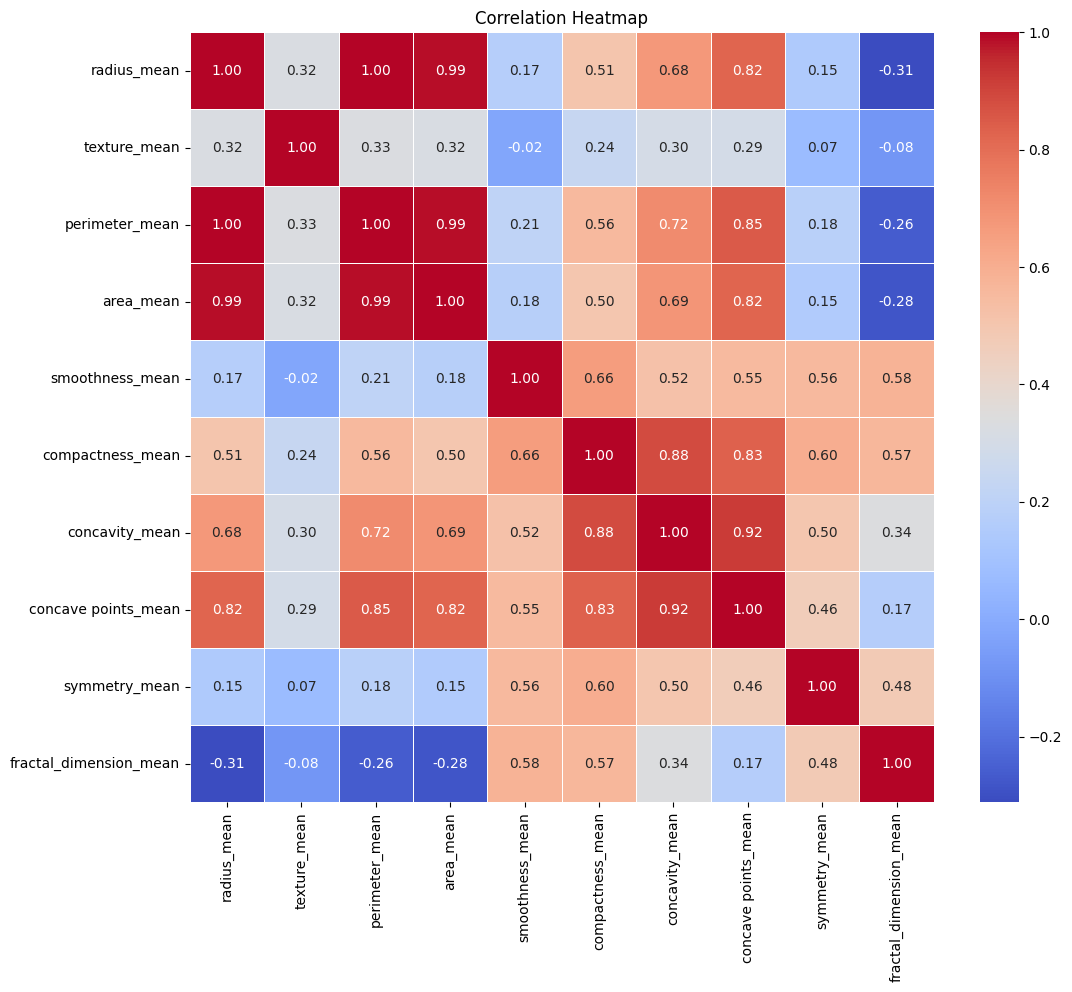

In [13]:
plt.figure(figsize=(12,10))
corr = df.drop(columns=['diagnosis']).corr()
sns.heatmap(corr.iloc[:10, :10], annot=True, cmap='coolwarm',
            linewidths=0.5, fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

In [14]:
df['diagnosis'] = df['diagnosis'].map({"M": 1, "B":0})

x = df.drop(columns=['diagnosis'])
y = df['diagnosis']

In [15]:
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

In [16]:
xtrain, xtest, ytrain, ytest = train_test_split(x_scaled, y, test_size=0.2,
                                                random_state=42,
                                                stratify=y)

In [18]:
class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(ytrain), y=ytrain)

weight_dict = dict(zip(np.unique(ytrain), class_weights))
sample_weights = np.array([weight_dict[label] for label in ytrain])

In [19]:
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss',
                          random_state=42)
model.fit(xtrain, ytrain, sample_weight=sample_weights)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [20]:
ypred = model.predict(xtest)
ypred_probab = model.predict_proba(xtest)[:, 1]

auc = roc_auc_score(ytest, ypred_probab)
print('AUC:', auc)
print('Classification Report:')
print(classification_report(ytest, ypred))

AUC: 0.990079365079365
Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98        72
           1       1.00      0.93      0.96        42

    accuracy                           0.97       114
   macro avg       0.98      0.96      0.97       114
weighted avg       0.97      0.97      0.97       114



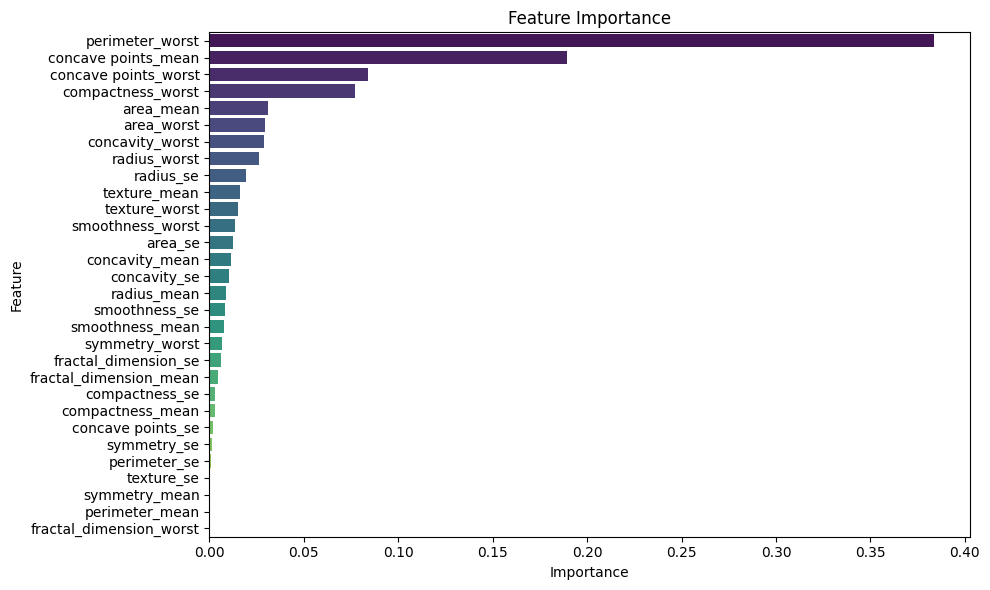

In [23]:
importances = model.feature_importances_
feature_names = df.drop(columns=['diagnosis']).columns
feat_imp_df = pd.DataFrame({'Feature': feature_names,
                            'Importance': importances})
feat_imp_df = feat_imp_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feat_imp_df, palette='viridis')
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

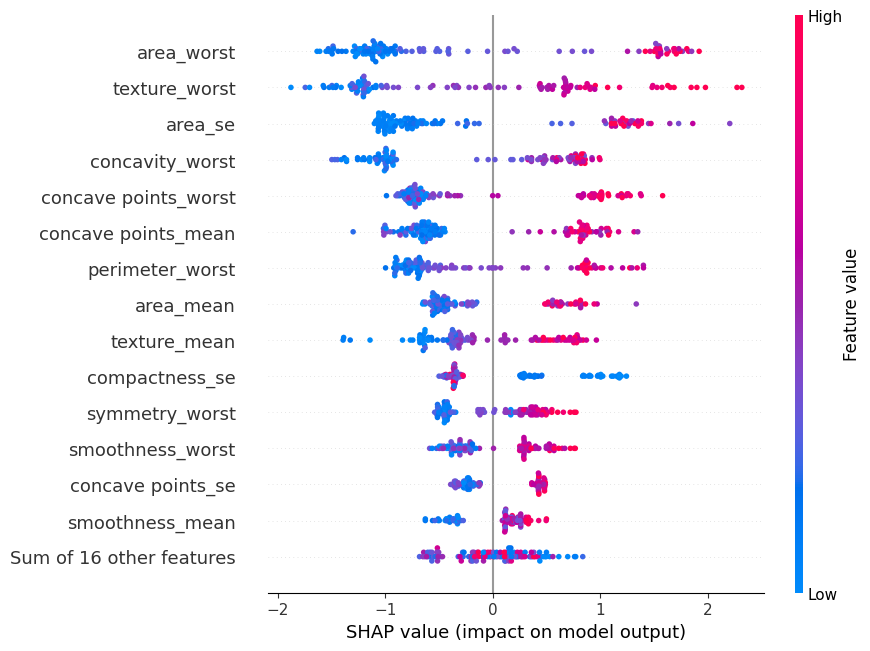

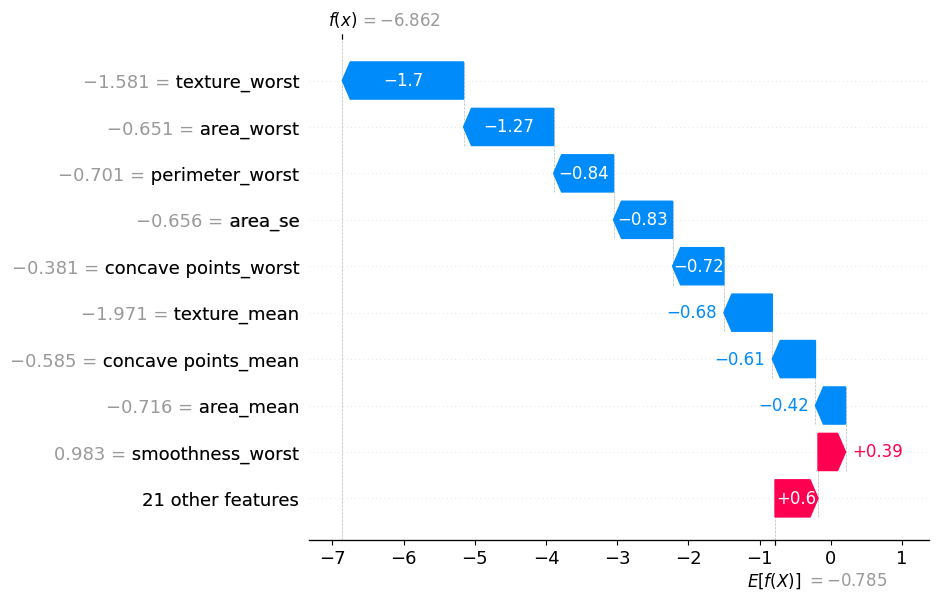

In [24]:
explainer = shap.Explainer(model, xtrain)

xtest_named = pd.DataFrame(xtest, columns=x.columns)
shap_values = explainer(xtest_named)

shap.plots.beeswarm(shap_values, max_display=15)
shap.plots.waterfall(shap_values[0])